## Classifier Baseline

В этом ноутбуке производится обучение классификатора, который по изображению коктейля предсказывает набор ингредиентов.

In [1]:
from pprint import pprint
import random
from PIL import Image
import json

import pickle
import math
from glob import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from openvino.runtime import Core
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
import timm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
sns.set(style='darkgrid', font_scale=1.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
random.seed(0)
np.random.seed(0)

cuda


### Подготовка данных для обучения:

Получаем список коктейлей (наименование коктейля соответствует наименованию каталога)

In [2]:
cockt_list = glob('/home/maksim/Cocktails/Images/Coctails_raw/*', )
cockt_list = sorted([x[43:] for x in cockt_list])

Читаем из конфига (json заполняется руками) наименования ингредиентов на двух языках.

In [41]:
# Opening ingredients JSON config
with open('config/ingredients.json', 'r') as f:
    ingedients_config = json.load(f)

class_labels = ingedients_config["idx"]
id2rus_genitive = ingedients_config["id2rus_genitive"]
class_labels_ru = np.array([id2rus_genitive[idx] for idx in class_labels])

class_dict = dict()
for i in range(len(class_labels)):
    class_dict[class_labels[i]] = i

Проверяем, что русскоязычные наименования соответствуют идентификаторам.

In [7]:
for idx, rus in zip(class_labels, class_labels_ru):
    print(idx, ' = ', rus)

orange_juice  =  апельсиновый сок
pinapple_juice  =  ананасовый сок
cranberry_juice  =  клюквенный сок
tomato_juice  =  томатный сок
tonic  =  тоник
energy  =  энергетик
sprite  =  спрайт
cola  =  колу
wine  =  красное вино
whiskey  =  виски
vodka  =  водку
gin  =  джин
rum  =  ром
tequila  =  текилу
lemon_juice  =  сок лимона или лайма
blue_curacao  =  ликёр Blue Curacao
coffee_liq  =  кофейный ликёр
irish_cream  =  сливочный ликёр "irish cream"
orange_liq  =  апельсиновый ликёр
peach_liq  =  персиковый ликёр
coconut_liq  =  кокосовый ликёр
blackcurrant_liq  =  смородиновый или вишнёвый ликёр
red_bitter  =  красный биттер
vermouth  =  вермут
coconut_syr  =  кокосовый сироп
grenadine  =  сироп Гренадин
sugar_syr  =  сахарный сироп
beer  =  пиво
lemon  =  лимон
lime  =  лайм
mint  =  мяту
olives  =  оливки
orange_peel  =  корку или дольку апельсина для украшения
strawberry  =  клубнику
tea  =  чай
coffee  =  кофе
milk  =  молоко
cream  =  сливки
chocolate  =  шоколад
ice_cream  =  морож

Читаем из конфига (json заполняется руками) рецепты коктейлей.

In [8]:
# Opening recipes JSON config
with open('config/recipes.json', 'r') as f:
    text_recipes = json.load(f)

Проверяем, что перечень ингредиентов в двух конфигах совпадает:

In [10]:
ing_set = set()
for rec in text_recipes:
    ing_set.update(text_recipes[rec])
    
print(all(a == b for a, b in zip(sorted(ing_set), sorted(class_labels))))
print(len(ing_set) == len(class_labels))

True
True


Проверяем, что список коктейлей в каталоге совпадает со списком в конфиге:

In [11]:
print(all(folder == conf for folder, conf in zip(cockt_list, text_recipes.keys())))
print(len(cockt_list) == len(text_recipes))

True
True


Формируем векторные представления рецептов.

In [42]:
recipes = dict()
for cocktail, recipe in text_recipes.items():
    arr = torch.zeros(len(class_labels), dtype=torch.int)
    arr[[class_dict[ingr] for ingr in recipe]] = 1
    recipes[cocktail] = arr

Задаём размер изображения, каталог с изображениями (убучающей выборкой) и константы нормализации:

In [43]:
# Opening model JSON config
with open('config/model.json', 'r') as f:
    model_conf = json.load(f)

In [44]:
image_size = model_conf['image_size']
crop_size = model_conf['crop_size']
DATA_DIR = '/home/maksim/Cocktails/Images/Coctails_raw/'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
print(f'Imge size = {image_size}x{image_size}')
print(f'Crop size = {crop_size}x{crop_size}')

Imge size = 160x160


In [65]:
def show_generated_images(generated):
    clear_output(wait=True)
    plt.figure(figsize=(24, 8))
    for k in range(len(generated)):
        plt.subplot(1, len(generated), k+1)
        plt.imshow(denorm(np.rollaxis(generated[k].numpy(), 0, 3)))
        plt.axis('off')
    plt.show()

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=200):
    fig, ax = plt.subplots(figsize=(60, 60))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [68]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for batch in self.dataloader: 
            yield to_device(batch, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

    
def get_dataloaders(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DeviceDataLoader object 
    """
  
    full_set = ImageFolder(DATA_DIR, 
                           transform=tt.Compose([
                                  #tt.Resize(image_size),
                                  #tt.CenterCrop(image_size),
                                  #tt.ToTensor(),
                                  #tt.RandomHorizontalFlip(),
                                  #tt.Normalize(*stats)])
                           
                                  tt.Resize(crop_size),
                                  tt.CenterCrop(crop_size),
                                  tt.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15, hue=0.01),
                                  tt.ToTensor(),
                                  tt.Normalize(*stats),
                                  tt.RandomCrop(image_size),
                                  tt.RandomHorizontalFlip() ])
                               )
    
    recipe_labels = torch.zeros((len(full_set.classes), len(class_labels)))
    for cockt, idx in full_set.class_to_idx.items():
        recipe_labels[idx] = recipes[cockt]
    
    
    n = len(full_set)  
    n_test = int(0.2 * n)  
    permutation = list(range(n))
    random.Random(42).shuffle(permutation)
    train_set = torch.utils.data.Subset(full_set, permutation[n_test: n])  
    test_set = torch.utils.data.Subset(full_set, permutation[:n_test])  
    
    train_dataloader = DataLoader(train_set, batch_size, shuffle=True, num_workers=5, pin_memory=True)
    test_dataloader = DataLoader(test_set, batch_size, shuffle=True, num_workers=5, pin_memory=True)

    return DeviceDataLoader(train_dataloader, device), DeviceDataLoader(test_dataloader, device), recipe_labels

Взглянем на аугментированные изображения:

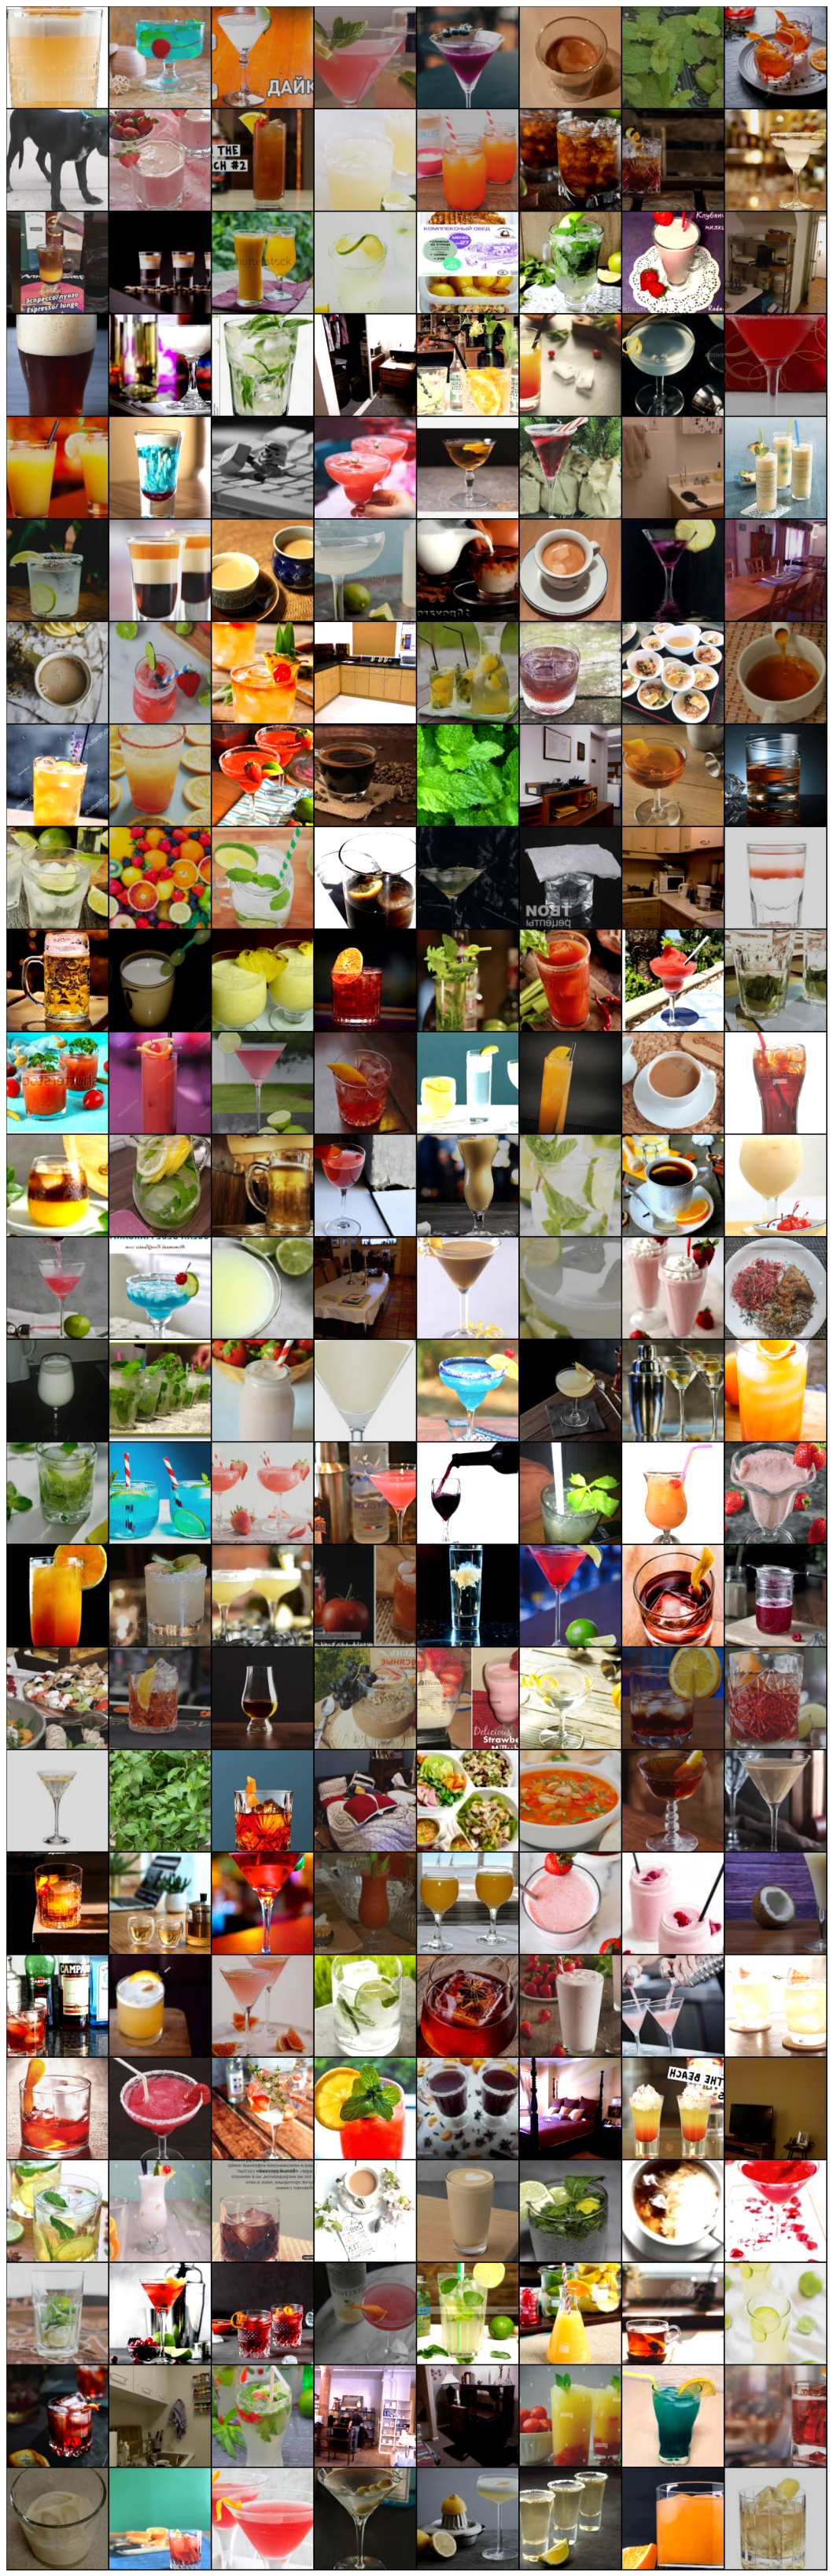

In [69]:
batch_size = 200
train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
show_images(next(iter(val_loader))[0].cpu())

### Обучение нейронной сети.

In [70]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler, threshold=0.5):
    running_loss = 0.0
    running_recall = 0
    running_precision = 0
    processed_data = 0
  
    for inputs, labels_idx in train_loader:
        inputs = inputs.to(device)
        labels = recipe_labels[labels_idx]
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = (outputs > threshold) * 1
        running_loss += loss.item() * inputs.size(0)
        running_recall += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(labels.data) + 0.1) * inputs.size(0)
        running_precision += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(preds.data) + 0.1) * inputs.size(0)
        processed_data += inputs.size(0)
    sheduler.step()
    train_loss = running_loss / processed_data
    recall = running_recall.double() / processed_data
    precision = running_precision.double() / processed_data
    train_acc = (2*recall*precision) / (precision+recall) 
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0.0
    running_recall = 0
    running_precision = 0
    processed_size = 0

    for inputs, labels_idx in val_loader:
        inputs = inputs.to(device)
        labels = recipe_labels[labels_idx]
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = (outputs > threshold) * 1

        running_loss += loss.item() * inputs.size(0)
        running_recall += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(labels.data) + 0.1) * inputs.size(0)
        running_precision += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(preds.data) + 0.1) * inputs.size(0)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    recall = running_recall.double() / processed_size
    precision = running_precision.double() / processed_size
    val_acc = (2*recall*precision) / (precision+recall) 
    return val_loss, val_acc

def train(train_loader, val_loader, model, epochs, optimizer, gamma=0.95):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        sheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, sheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = torch.sigmoid(torch.cat(logits), dim=-1).numpy()
    return probs


def eval_model(model, val_loader):
    with torch.no_grad():
        logits = []
        labels = [] 
    
        for inputs, labels_b in val_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            labels.append(labels_b)
            
    probs = torch.sigmoid(torch.cat(logits), dim=-1).numpy()
    return probs, labels

В качестве нейронной сети для обучения выбрана предобученная MobilenetV3. \
Немного меняем структуру сети: 
1. Послендий полносвязный слой заменяем двумя слоями, bottleneck размерности 14 и финальный классификатор с размерностью, равной количеству ингредиентов.
2. Немного уменьшаем размерность 6-го блока для того, чтобы снизить сложность сети и увеличить её стойкость к переобучению.

In [71]:
model = timm.create_model('mobilenetv3_large_100_miil', pretrained=True).to(device) 

model.classifier = nn.Sequential(
    nn.Linear(in_features=256, out_features=16, bias=False),
    nn.BatchNorm1d(16),
    nn.Linear(in_features=16, out_features=len(class_labels))).to(device)

model.blocks[6][0].conv = nn.Conv2d(160, 256, 1, 1).to(device)
model.blocks[6][0].bn1 = nn.BatchNorm2d(256).to(device)
model.conv_head = nn.Conv2d(256, 256, 1, 1).to(device)

for name, param in model.named_parameters():
    param.requires_grad_(False)

Поучившаяся структура модели:

In [72]:
model

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Hardswish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Размораживаем часть градиентов:

In [73]:
#model.blocks[1].requires_grad_(True)
model.blocks[2].requires_grad_(True)
model.blocks[3].requires_grad_(True)
model.blocks[4].requires_grad_(True)
model.blocks[5].requires_grad_(True)
model.blocks[6].requires_grad_(True)

model.conv_head.requires_grad_(True)
model.classifier.requires_grad_(True)

for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight False
bn1.weight False
bn1.bias False
blocks.0.0.conv_dw.weight False
blocks.0.0.bn1.weight False
blocks.0.0.bn1.bias False
blocks.0.0.conv_pw.weight False
blocks.0.0.bn2.weight False
blocks.0.0.bn2.bias False
blocks.1.0.conv_pw.weight False
blocks.1.0.bn1.weight False
blocks.1.0.bn1.bias False
blocks.1.0.conv_dw.weight False
blocks.1.0.bn2.weight False
blocks.1.0.bn2.bias False
blocks.1.0.conv_pwl.weight False
blocks.1.0.bn3.weight False
blocks.1.0.bn3.bias False
blocks.1.1.conv_pw.weight False
blocks.1.1.bn1.weight False
blocks.1.1.bn1.bias False
blocks.1.1.conv_dw.weight False
blocks.1.1.bn2.weight False
blocks.1.1.bn2.bias False
blocks.1.1.conv_pwl.weight False
blocks.1.1.bn3.weight False
blocks.1.1.bn3.bias False
blocks.2.0.conv_pw.weight True
blocks.2.0.bn1.weight True
blocks.2.0.bn1.bias True
blocks.2.0.conv_dw.weight True
blocks.2.0.bn2.weight True
blocks.2.0.bn2.bias True
blocks.2.0.se.conv_reduce.weight True
blocks.2.0.se.conv_reduce.bias True
blocks.2.0.se.c

Для того чтобы максимально сохранить информацию в предобученной сети, устанавливаем разные скорости обучения для различных групп слоёв: чем ближе в выходу сети, тем выше скорость обучения. Вводим новый гиперпараметр lr_decay, который определяет, насколько будут отличаться веса на разных уровнях.

In [74]:
def get_optimizer(lr: float, lr_decay: float) -> object:
    optimizer = torch.optim.Adam([
        {'params': model.conv_stem.parameters()},
        {'params': model.bn1.parameters()},
        {'params': model.blocks[0].parameters(), 'lr': lr/lr_decay**7},
        {'params': model.blocks[1].parameters(), 'lr': lr/lr_decay**6},
        {'params': model.blocks[2].parameters(), 'lr': lr/lr_decay**5},
        {'params': model.blocks[3].parameters(), 'lr': lr/lr_decay**4},
        {'params': model.blocks[4].parameters(), 'lr': lr/lr_decay**3},
        {'params': model.blocks[5].parameters(), 'lr': lr/lr_decay**2},
        {'params': model.blocks[6].parameters(), 'lr': lr/lr_decay**1},
        {'params': model.conv_head.parameters(), 'lr': lr/lr_decay**1},
        {'params': model.classifier.parameters(), 'lr': lr},
    ], lr=lr/lr_decay**8)
    return optimizer
    

Обучаем сеть в несколько циклов с различными значениями lr, lr_decay, batch_size:

In [75]:
lr = 5.0e-3
lr_decay = 6.0
batch_size = 200

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history1 = train(train_loader, val_loader, model=model, epochs=5, optimizer=optimizer, gamma=0.9)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.39232965671795905

Epoch 001 train_loss: 0.3923     val_loss 0.1711 train_acc 0.4078 val_acc 0.4967
loss 0.13137625310993617

Epoch 002 train_loss: 0.1314     val_loss 0.1237 train_acc 0.6522 val_acc 0.6711
loss 0.10269654059655152

Epoch 003 train_loss: 0.1027     val_loss 0.1152 train_acc 0.7349 val_acc 0.6940
loss 0.0880853492042499

Epoch 004 train_loss: 0.0881     val_loss 0.1090 train_acc 0.7768 val_acc 0.7167
loss 0.07703410843476913

Epoch 005 train_loss: 0.0770     val_loss 0.1077 train_acc 0.8086 val_acc 0.7472


[(0.39232965671795905,
  tensor(0.4078, device='cuda:0', dtype=torch.float64),
  0.1710620046176936,
  tensor(0.4967, device='cuda:0', dtype=torch.float64)),
 (0.13137625310993617,
  tensor(0.6522, device='cuda:0', dtype=torch.float64),
  0.12370353117631719,
  tensor(0.6711, device='cuda:0', dtype=torch.float64)),
 (0.10269654059655152,
  tensor(0.7349, device='cuda:0', dtype=torch.float64),
  0.11516390192665062,
  tensor(0.6940, device='cuda:0', dtype=torch.float64)),
 (0.0880853492042499,
  tensor(0.7768, device='cuda:0', dtype=torch.float64),
  0.10900979383332628,
  tensor(0.7167, device='cuda:0', dtype=torch.float64)),
 (0.07703410843476913,
  tensor(0.8086, device='cuda:0', dtype=torch.float64),
  0.10774514012390839,
  tensor(0.7472, device='cuda:0', dtype=torch.float64))]

In [76]:
lr = 3.5e-3
lr_decay = 2.3
batch_size = 80

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history2 = train(train_loader, val_loader, model=model, epochs=10, optimizer=optimizer, gamma=0.9)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.11026865624680421

Epoch 001 train_loss: 0.1103     val_loss 0.1183 train_acc 0.7179 val_acc 0.7094
loss 0.0915697226371115

Epoch 002 train_loss: 0.0916     val_loss 0.1045 train_acc 0.7713 val_acc 0.7573
loss 0.07721932146299826

Epoch 003 train_loss: 0.0772     val_loss 0.1020 train_acc 0.8124 val_acc 0.7523
loss 0.0670166613920387

Epoch 004 train_loss: 0.0670     val_loss 0.1043 train_acc 0.8392 val_acc 0.7804
loss 0.05882518164834845

Epoch 005 train_loss: 0.0588     val_loss 0.1006 train_acc 0.8614 val_acc 0.7837
loss 0.05088770982423798

Epoch 006 train_loss: 0.0509     val_loss 0.1102 train_acc 0.8797 val_acc 0.7839
loss 0.04236431101750512

Epoch 007 train_loss: 0.0424     val_loss 0.1189 train_acc 0.9004 val_acc 0.8013
loss 0.03514697249700571

Epoch 008 train_loss: 0.0351     val_loss 0.1029 train_acc 0.9178 val_acc 0.8091
loss 0.030531679256110337

Epoch 009 train_loss: 0.0305     val_loss 0.1156 train_acc 0.9296 val_acc 0.8071
loss 0.026775462256520093

Epoch 010 t

[(0.11026865624680421,
  tensor(0.7179, device='cuda:0', dtype=torch.float64),
  0.11828612079508424,
  tensor(0.7094, device='cuda:0', dtype=torch.float64)),
 (0.0915697226371115,
  tensor(0.7713, device='cuda:0', dtype=torch.float64),
  0.10453803587550549,
  tensor(0.7573, device='cuda:0', dtype=torch.float64)),
 (0.07721932146299826,
  tensor(0.8124, device='cuda:0', dtype=torch.float64),
  0.10195406970755895,
  tensor(0.7523, device='cuda:0', dtype=torch.float64)),
 (0.0670166613920387,
  tensor(0.8392, device='cuda:0', dtype=torch.float64),
  0.1043041215795739,
  tensor(0.7804, device='cuda:0', dtype=torch.float64)),
 (0.05882518164834845,
  tensor(0.8614, device='cuda:0', dtype=torch.float64),
  0.10059622920450043,
  tensor(0.7837, device='cuda:0', dtype=torch.float64)),
 (0.05088770982423798,
  tensor(0.8797, device='cuda:0', dtype=torch.float64),
  0.11023798379399442,
  tensor(0.7839, device='cuda:0', dtype=torch.float64)),
 (0.04236431101750512,
  tensor(0.9004, device='c

In [77]:
lr = 3.5e-3
lr_decay = 2.2
batch_size = 64

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history3 = train(train_loader, val_loader, model=model, epochs=8, optimizer=optimizer, gamma=0.9)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 0.06235942445305713

Epoch 001 train_loss: 0.0624     val_loss 0.1093 train_acc 0.8554 val_acc 0.7701
loss 0.05515997670775058

Epoch 002 train_loss: 0.0552     val_loss 0.1222 train_acc 0.8720 val_acc 0.7691
loss 0.052866447418579175

Epoch 003 train_loss: 0.0529     val_loss 0.1019 train_acc 0.8783 val_acc 0.7792
loss 0.04331267497563095

Epoch 004 train_loss: 0.0433     val_loss 0.1173 train_acc 0.9002 val_acc 0.7915
loss 0.03523296185871167

Epoch 005 train_loss: 0.0352     val_loss 0.1199 train_acc 0.9195 val_acc 0.7986
loss 0.03250628890929637

Epoch 006 train_loss: 0.0325     val_loss 0.1080 train_acc 0.9259 val_acc 0.8062
loss 0.026950443035072564

Epoch 007 train_loss: 0.0270     val_loss 0.1297 train_acc 0.9398 val_acc 0.8040
loss 0.021855945755867422

Epoch 008 train_loss: 0.0219     val_loss 0.1184 train_acc 0.9500 val_acc 0.8123


[(0.06235942445305713,
  tensor(0.8554, device='cuda:0', dtype=torch.float64),
  0.10928776555186805,
  tensor(0.7701, device='cuda:0', dtype=torch.float64)),
 (0.05515997670775058,
  tensor(0.8720, device='cuda:0', dtype=torch.float64),
  0.12223132604637321,
  tensor(0.7691, device='cuda:0', dtype=torch.float64)),
 (0.052866447418579175,
  tensor(0.8783, device='cuda:0', dtype=torch.float64),
  0.1018605311320718,
  tensor(0.7792, device='cuda:0', dtype=torch.float64)),
 (0.04331267497563095,
  tensor(0.9002, device='cuda:0', dtype=torch.float64),
  0.11731570194860834,
  tensor(0.7915, device='cuda:0', dtype=torch.float64)),
 (0.03523296185871167,
  tensor(0.9195, device='cuda:0', dtype=torch.float64),
  0.1198806892456101,
  tensor(0.7986, device='cuda:0', dtype=torch.float64)),
 (0.03250628890929637,
  tensor(0.9259, device='cuda:0', dtype=torch.float64),
  0.10804433619838914,
  tensor(0.8062, device='cuda:0', dtype=torch.float64)),
 (0.026950443035072564,
  tensor(0.9398, device

In [78]:
lr = 3.5e-3
lr_decay = 2.1
batch_size = 64

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history4 = train(train_loader, val_loader, model=model, epochs=5, optimizer=optimizer, gamma=0.85)

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 0.05883815366229042

Epoch 001 train_loss: 0.0588     val_loss 0.1241 train_acc 0.8667 val_acc 0.7699
loss 0.04912400650630666

Epoch 002 train_loss: 0.0491     val_loss 0.1098 train_acc 0.8882 val_acc 0.7940
loss 0.03886338060093118

Epoch 003 train_loss: 0.0389     val_loss 0.1192 train_acc 0.9136 val_acc 0.7935
loss 0.0321629400411342

Epoch 004 train_loss: 0.0322     val_loss 0.1178 train_acc 0.9280 val_acc 0.8021
loss 0.02756508437443099

Epoch 005 train_loss: 0.0276     val_loss 0.1200 train_acc 0.9381 val_acc 0.7982
loss 0.020535256639859684

Epoch 006 train_loss: 0.0205     val_loss 0.1273 train_acc 0.9542 val_acc 0.8123
loss 0.015688960044129795

Epoch 007 train_loss: 0.0157     val_loss 0.1449 train_acc 0.9643 val_acc 0.8104
loss 0.01333870417415425

Epoch 008 train_loss: 0.0133     val_loss 0.1462 train_acc 0.9705 val_acc 0.8119
loss 0.012559488544111184

Epoch 009 train_loss: 0.0126     val_loss 0.1459 train_acc 0.9719 val_acc 0.8183


[(0.05883815366229042,
  tensor(0.8667, device='cuda:0', dtype=torch.float64),
  0.12406455805533327,
  tensor(0.7699, device='cuda:0', dtype=torch.float64)),
 (0.04912400650630666,
  tensor(0.8882, device='cuda:0', dtype=torch.float64),
  0.10980997387922457,
  tensor(0.7940, device='cuda:0', dtype=torch.float64)),
 (0.03886338060093118,
  tensor(0.9136, device='cuda:0', dtype=torch.float64),
  0.11924553053291073,
  tensor(0.7935, device='cuda:0', dtype=torch.float64)),
 (0.0321629400411342,
  tensor(0.9280, device='cuda:0', dtype=torch.float64),
  0.11783478737913666,
  tensor(0.8021, device='cuda:0', dtype=torch.float64)),
 (0.02756508437443099,
  tensor(0.9381, device='cuda:0', dtype=torch.float64),
  0.11997488877867306,
  tensor(0.7982, device='cuda:0', dtype=torch.float64)),
 (0.020535256639859684,
  tensor(0.9542, device='cuda:0', dtype=torch.float64),
  0.12726323893605923,
  tensor(0.8123, device='cuda:0', dtype=torch.float64)),
 (0.015688960044129795,
  tensor(0.9643, devic

In [79]:
lr = 3.5e-3 
lr_decay = 2.8 
batch_size = 200

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history5 = train(val_loader, val_loader, model=model, epochs=12, optimizer=optimizer, gamma=0.85) 

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.09603094386819896

Epoch 001 train_loss: 0.0960     val_loss 0.0667 train_acc 0.7919 val_acc 0.8429
loss 0.06307454653240953

Epoch 002 train_loss: 0.0631     val_loss 0.0513 train_acc 0.8527 val_acc 0.8735
loss 0.04855792814264217

Epoch 003 train_loss: 0.0486     val_loss 0.0386 train_acc 0.8862 val_acc 0.9125
loss 0.036941776802527165

Epoch 004 train_loss: 0.0369     val_loss 0.0301 train_acc 0.9141 val_acc 0.9302
loss 0.03142992985306271

Epoch 005 train_loss: 0.0314     val_loss 0.0257 train_acc 0.9288 val_acc 0.9414
loss 0.02541690022017021

Epoch 006 train_loss: 0.0254     val_loss 0.0208 train_acc 0.9426 val_acc 0.9526
loss 0.02181583891777652

Epoch 007 train_loss: 0.0218     val_loss 0.0189 train_acc 0.9495 val_acc 0.9557
loss 0.018415791117307942

Epoch 008 train_loss: 0.0184     val_loss 0.0152 train_acc 0.9584 val_acc 0.9655
loss 0.015192123780512956

Epoch 009 train_loss: 0.0152     val_loss 0.0143 train_acc 0.9665 val_acc 0.9672
loss 0.013609303458757247

Epoch 0

[(0.09603094386819896,
  tensor(0.7919, device='cuda:0', dtype=torch.float64),
  0.06668805234660066,
  tensor(0.8429, device='cuda:0', dtype=torch.float64)),
 (0.06307454653240953,
  tensor(0.8527, device='cuda:0', dtype=torch.float64),
  0.0513091679626012,
  tensor(0.8735, device='cuda:0', dtype=torch.float64)),
 (0.04855792814264217,
  tensor(0.8862, device='cuda:0', dtype=torch.float64),
  0.03855454022432835,
  tensor(0.9125, device='cuda:0', dtype=torch.float64)),
 (0.036941776802527165,
  tensor(0.9141, device='cuda:0', dtype=torch.float64),
  0.030132188148565425,
  tensor(0.9302, device='cuda:0', dtype=torch.float64)),
 (0.03142992985306271,
  tensor(0.9288, device='cuda:0', dtype=torch.float64),
  0.0256821245603479,
  tensor(0.9414, device='cuda:0', dtype=torch.float64)),
 (0.02541690022017021,
  tensor(0.9426, device='cuda:0', dtype=torch.float64),
  0.020783100486989944,
  tensor(0.9526, device='cuda:0', dtype=torch.float64)),
 (0.02181583891777652,
  tensor(0.9495, devic

In [80]:
lr = 3.5e-3
lr_decay = 2.2
batch_size = 64

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history6 = train(train_loader, val_loader, model=model, epochs=6, optimizer=optimizer, gamma=0.85)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 0.043248521279317775

Epoch 001 train_loss: 0.0432     val_loss 0.0912 train_acc 0.9072 val_acc 0.8142
loss 0.03372132224405212

Epoch 002 train_loss: 0.0337     val_loss 0.0883 train_acc 0.9268 val_acc 0.8361
loss 0.026088627856520434

Epoch 003 train_loss: 0.0261     val_loss 0.0944 train_acc 0.9426 val_acc 0.8272
loss 0.020744740415675672

Epoch 004 train_loss: 0.0207     val_loss 0.0970 train_acc 0.9551 val_acc 0.8457
loss 0.016114361180540736

Epoch 005 train_loss: 0.0161     val_loss 0.0914 train_acc 0.9661 val_acc 0.8521
loss 0.011842491482744381

Epoch 006 train_loss: 0.0118     val_loss 0.1046 train_acc 0.9737 val_acc 0.8613


[(0.043248521279317775,
  tensor(0.9072, device='cuda:0', dtype=torch.float64),
  0.09120339872798348,
  tensor(0.8142, device='cuda:0', dtype=torch.float64)),
 (0.03372132224405212,
  tensor(0.9268, device='cuda:0', dtype=torch.float64),
  0.08831059070997826,
  tensor(0.8361, device='cuda:0', dtype=torch.float64)),
 (0.026088627856520434,
  tensor(0.9426, device='cuda:0', dtype=torch.float64),
  0.0943981405101715,
  tensor(0.8272, device='cuda:0', dtype=torch.float64)),
 (0.020744740415675672,
  tensor(0.9551, device='cuda:0', dtype=torch.float64),
  0.09695790487106183,
  tensor(0.8457, device='cuda:0', dtype=torch.float64)),
 (0.016114361180540736,
  tensor(0.9661, device='cuda:0', dtype=torch.float64),
  0.09139188865361401,
  tensor(0.8521, device='cuda:0', dtype=torch.float64)),
 (0.011842491482744381,
  tensor(0.9737, device='cuda:0', dtype=torch.float64),
  0.10459441899657622,
  tensor(0.8613, device='cuda:0', dtype=torch.float64))]

In [ ]:
lr = 2.5e-3 #1.5e-3
lr_decay = 3.5 #2.0
batch_size = 200

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history6 = train(val_loader, val_loader, model=model, epochs=8, optimizer=optimizer, gamma=0.85) 

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 0.0762200743183354

Epoch 001 train_loss: 0.0762     val_loss 0.0509 train_acc 0.8412 val_acc 0.8809


In [ ]:
lr = 0.3e-3 #1.5e-3
lr_decay = 2.3 #2.0
batch_size = 128

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history7 = train(train_loader, val_loader, model=model, epochs=1, optimizer=optimizer, gamma=0.5) 

Сохраняем модель, веса. При необходимости, загружаем веса.

In [ ]:
torch.save(model.state_dict(), 'classifier_state_dict.pl')
torch.save(model, 'classifier_model.pl')

In [31]:
model.load_state_dict(torch.load('classifier_state_dict.pl'))

<All keys matched successfully>

Проверим работу модели на случайном изображении:

In [ ]:
def predict_ingredients(path: str, model: callable, classes: np.array) -> list:
    try:
        image = Image.open(path)
    except:
        return []
    width, height = image.size  # Get dimensions
    size = min(width, height)
    

    left = (width - size) / 2
    top = (height - size) / 2
    right = (width + size) / 2
    bottom = (height + size) / 2

    # Crop the center of the image
    image = image.crop((left, top, right, bottom))
    img = np.asarray(image.resize((image_size, image_size))) / 127.5 - 1.0
    
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(denorm(img))
    plt.axis('off')
    plt.show()
    
    logits = model(torch.tensor(np.rollaxis(img, 2, 0)[None, :, :, :], dtype=torch.float).to(device))
    result = (logits.detach().cpu() > 0).nonzero()[:, 1].numpy()
    return classes[result]

In [ ]:
predict_ingredients('/home/maksim/Cocktails/Images/Coctails_raw/Bloody_mary/AD4A0735.jpg', model, class_labels_ru)

### Конвертация в ONNX

Загружаем модель в pytorch и экспортируем в формат ONNX.

In [ ]:
model.to('cpu')
model.load_state_dict(torch.load('classifier_state_dict.pl'))
# Evaluate the model to switch some operations from training mode to inference.
model.eval()
# Create dummy input for the model. It will be used to run the model inside export function.
dummy_input = torch.randn(1, 3, image_size, image_size)
# Call the export function
torch.onnx.export(model,               
                  dummy_input,                         
                  'classifier.onnx',   
                  export_params=True,        
                  opset_version=11,          
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['logits']
                 )

Загружаем модель ONNX для проверки:

In [ ]:
ie = Core()

Доступные для ONNX устройства:

In [ ]:
devices = ie.available_devices

for dev in devices:
    device_name = ie.get_property(device_name=dev, name="FULL_DEVICE_NAME")
    print(f"{dev}: {device_name}")
    
onnx_model_path = 'classifier.onnx'
model_onnx = ie.read_model(model=onnx_model_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

Вход модели:

In [ ]:
input_layer = compiled_model_onnx.input(0)

print(f"input precision: {input_layer.element_type}")
print(f"input shape: {input_layer.shape}")

Выход модели:

In [ ]:
output_layer = compiled_model_onnx.output(0)

print(f"output precision: {output_layer.element_type}")
print(f"output shape: {output_layer.shape}")

Вся загрузка в одной ячейке:

In [ ]:
ie = Core()
onnx_model_path = 'classifier_083.onnx'
model_onnx = ie.read_model(model=onnx_model_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

input_layer = compiled_model_onnx.input(0)
output_layer = compiled_model_onnx.output(0)

Пробуем инференс на случайном изображении:

In [ ]:
def predict_ingredients(path: str, class_labels: list) -> list:
    img = np.asarray(Image.open(path).resize((image_size, image_size))) / 255
    logits = compiled_model_onnx([np.rollaxis(img, 2, 0)[None, :, :, :]])[output_layer]
    result = (logits > 0).nonzero()[1]
    return class_labels_ru[result]

def generate_recipe(ingredients: list) -> str:
    return ', '.join(ingredients)

In [ ]:
img_path = '/home/maksim/Cocktails/Images/Coctails_raw/Mojito/0346a20835_1000.jpg'
print(generate_recipe(predict_ingredients(img_path, class_labels=class_labels_ru)))